In [25]:
%%javascript
// Disable adding scrolling for outputs
require(
        ["notebook/js/outputarea"],
        function (oa) {
            oa.OutputArea.auto_scroll_threshold = -1;
        });

<IPython.core.display.Javascript object>

In [26]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib as mpl
import matplotlib.pyplot as plt
#import datetime
import json
import pandas as pd
#import numpy as np


%matplotlib inline
#%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 75
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['axes.formatter.useoffset'] = False

pd.set_option("display.max_rows", 100)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', 1000)

In [27]:
def load_results(filename: str):
    algo_prefix_len_to_remove = len('algo')
    def normalize(d):
        d['input'] = d['input_file'].rsplit('/', 1)[1]
        return d
    with open(filename) as f:
        return [normalize(json.loads(l)) for l in f]

In [28]:
all_algos = {
    'naive': 1,
    'naiveLessBranches': 1,
    'naiveTableChar': 1,
    'naiveTableInt': 1,

    'autoVec_32': 2,
    'autoVec_64': 2,
    'autoVec_128_WithOverflow': 3,
    'autoVec_128': 2,
    'autoVec_128_IntStepCounter': 2,
    'autoVec_256': 2,
    'autoVec_256_IntStepCounter': 2,
    'autoVec_512': 2,
    'autoVec_1024': 2,
    'autoVec_2048': 2,

    'manualVec_32': 4,
    'manualVec_64': 4,
    'manualVec_128': 4,
    'manualVec_256': 4,
    'manualVec_512': 4,
    'manualVec_1024': 4,
    'manualVec_2048': 4,

    'manualVecSize_32': 5,
    'manualVecSize_64': 5,
    'manualVecSize_128': 5,
    'manualVecSize_256': 5,
    'manualVecSize_512': 5,
    'manualVecSize_1024': 5,
    'manualVecSize_2048': 5,

    'manualVecStrlen_32': 6,
    'manualVecStrlen_64': 6,
    'manualVecStrlen_128': 6,
    'manualVecStrlen_256': 6,
    'manualVecStrlen_512': 6,
    'manualVecStrlen_1024': 6,
    'manualVecStrlen_2048': 6,
}

COLORS = {
    1: 'bisque',
    2: 'dodgerblue',
    3: 'darkred',
    4: 'lightpink',
    4: 'lightpink',
    5: 'olive',
    6: 'paleturquoise',
}

HATCHES = {
    1: '',
    2: '',
    3: 'xx',
    4: '..',
    4: '..',
    5: 'x',
    6: '',
}

def make_sorter():
    sort_order = {k: v for v, k in enumerate(all_algos.keys())}
    return lambda s: s.map(lambda x: sort_order[x])

In [29]:
NUM_RUNS = 10

arch_runs = {
    'amd': 'run-amd.log',
    'icelake-aws': 'run-icelake-aws.txt',
}

data = {n: pd.DataFrame(load_results(fn)) for n, fn in arch_runs.items()}

In [30]:
def rsd(x):
    return x.std() / x.mean() * 100

for arch, df in data.items():
    print(arch)
    print(df.groupby(['algo', 'input'])['mib_per_s'].agg(['max', 'min', 'mean', rsd]))

amd
                                       max    min     mean       rsd
algo                       input                                    
autoVec_1024               long.txt  10942  10751  10832.8  0.603417
                           wp.txt    17553  15329  17177.3  3.979226
autoVec_128                long.txt  10749  10533  10597.7  0.575142
                           wp.txt    16978  14467  16492.1  4.684920
autoVec_128_IntStepCounter long.txt   7531   6825   7436.9  2.902059
                           wp.txt     8029   7382   7910.6  2.366167
autoVec_128_WithOverflow   long.txt  12051  11977  11992.3  0.182567
                           wp.txt    34663  32530  34022.2  1.848353
autoVec_2048               long.txt  11674  11155  11502.8  1.393233
                           wp.txt    17027  16107  16823.5  1.598074
autoVec_256                long.txt  11211  11053  11120.3  0.485248
                           wp.txt    18443  17814  18264.3  1.264319
autoVec_256_IntStepCounter lon

# Comparison of processing speed for null-terminated input

Variants:
- **algoHabrNaive** - original, the most naive algorithm from Habr
- **algoHabrLessBranches** - algorithm from Habr that uses conditional move instead of branching
- **algoHabrTableChar** - algorithm from Habr that uses a table with `signed char` values (-1, 0, 1) 
- **algoHabrTableInt** - algorithm from Habr that uses a table with `int` values (-1, 0, 1)
- **algoHabrVectorized** - compiler-generated SIMD-based optimization from Habr that uses `signed char` for step sizes < 128 and `short` otherwise
- **algoHabrVectorized_128_WithOverflow** - original version of **algoHabrVectorized** that uses `signed char` step counter with step sizes 128 hence suffer from a step counter overflow
- **algoHabrVectorized_XXX_IntStepResult** - version of **algoHabrVectorized** that uses `int` for step counter
- **autoVec** - manually written SIMD-based algorithm

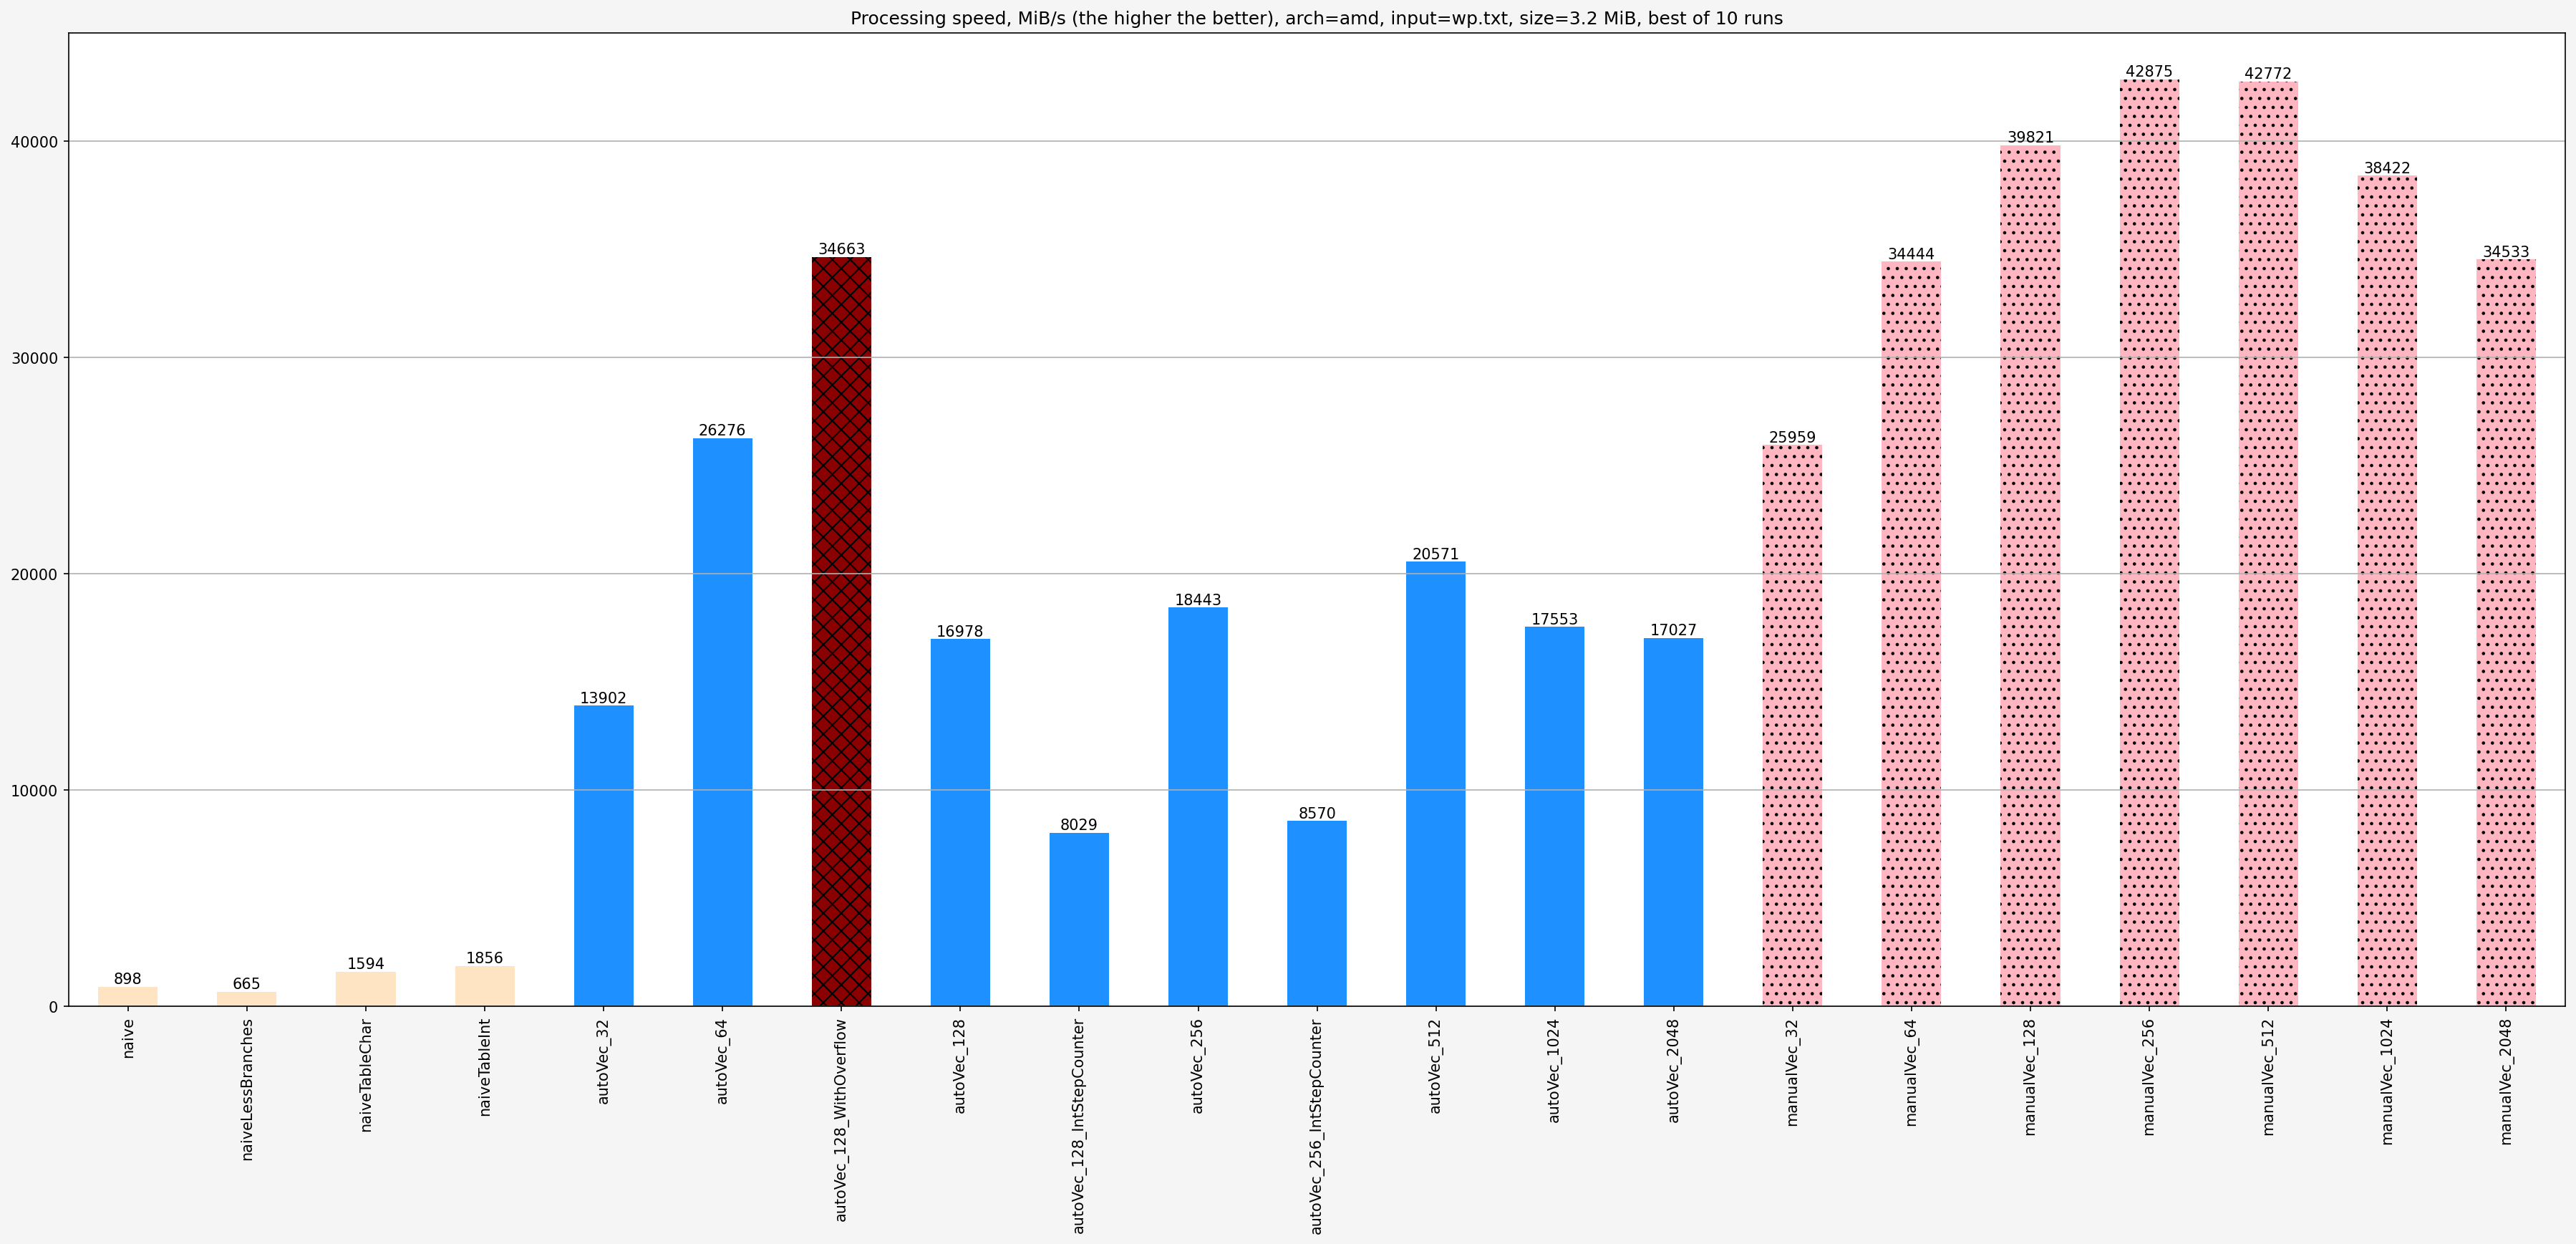

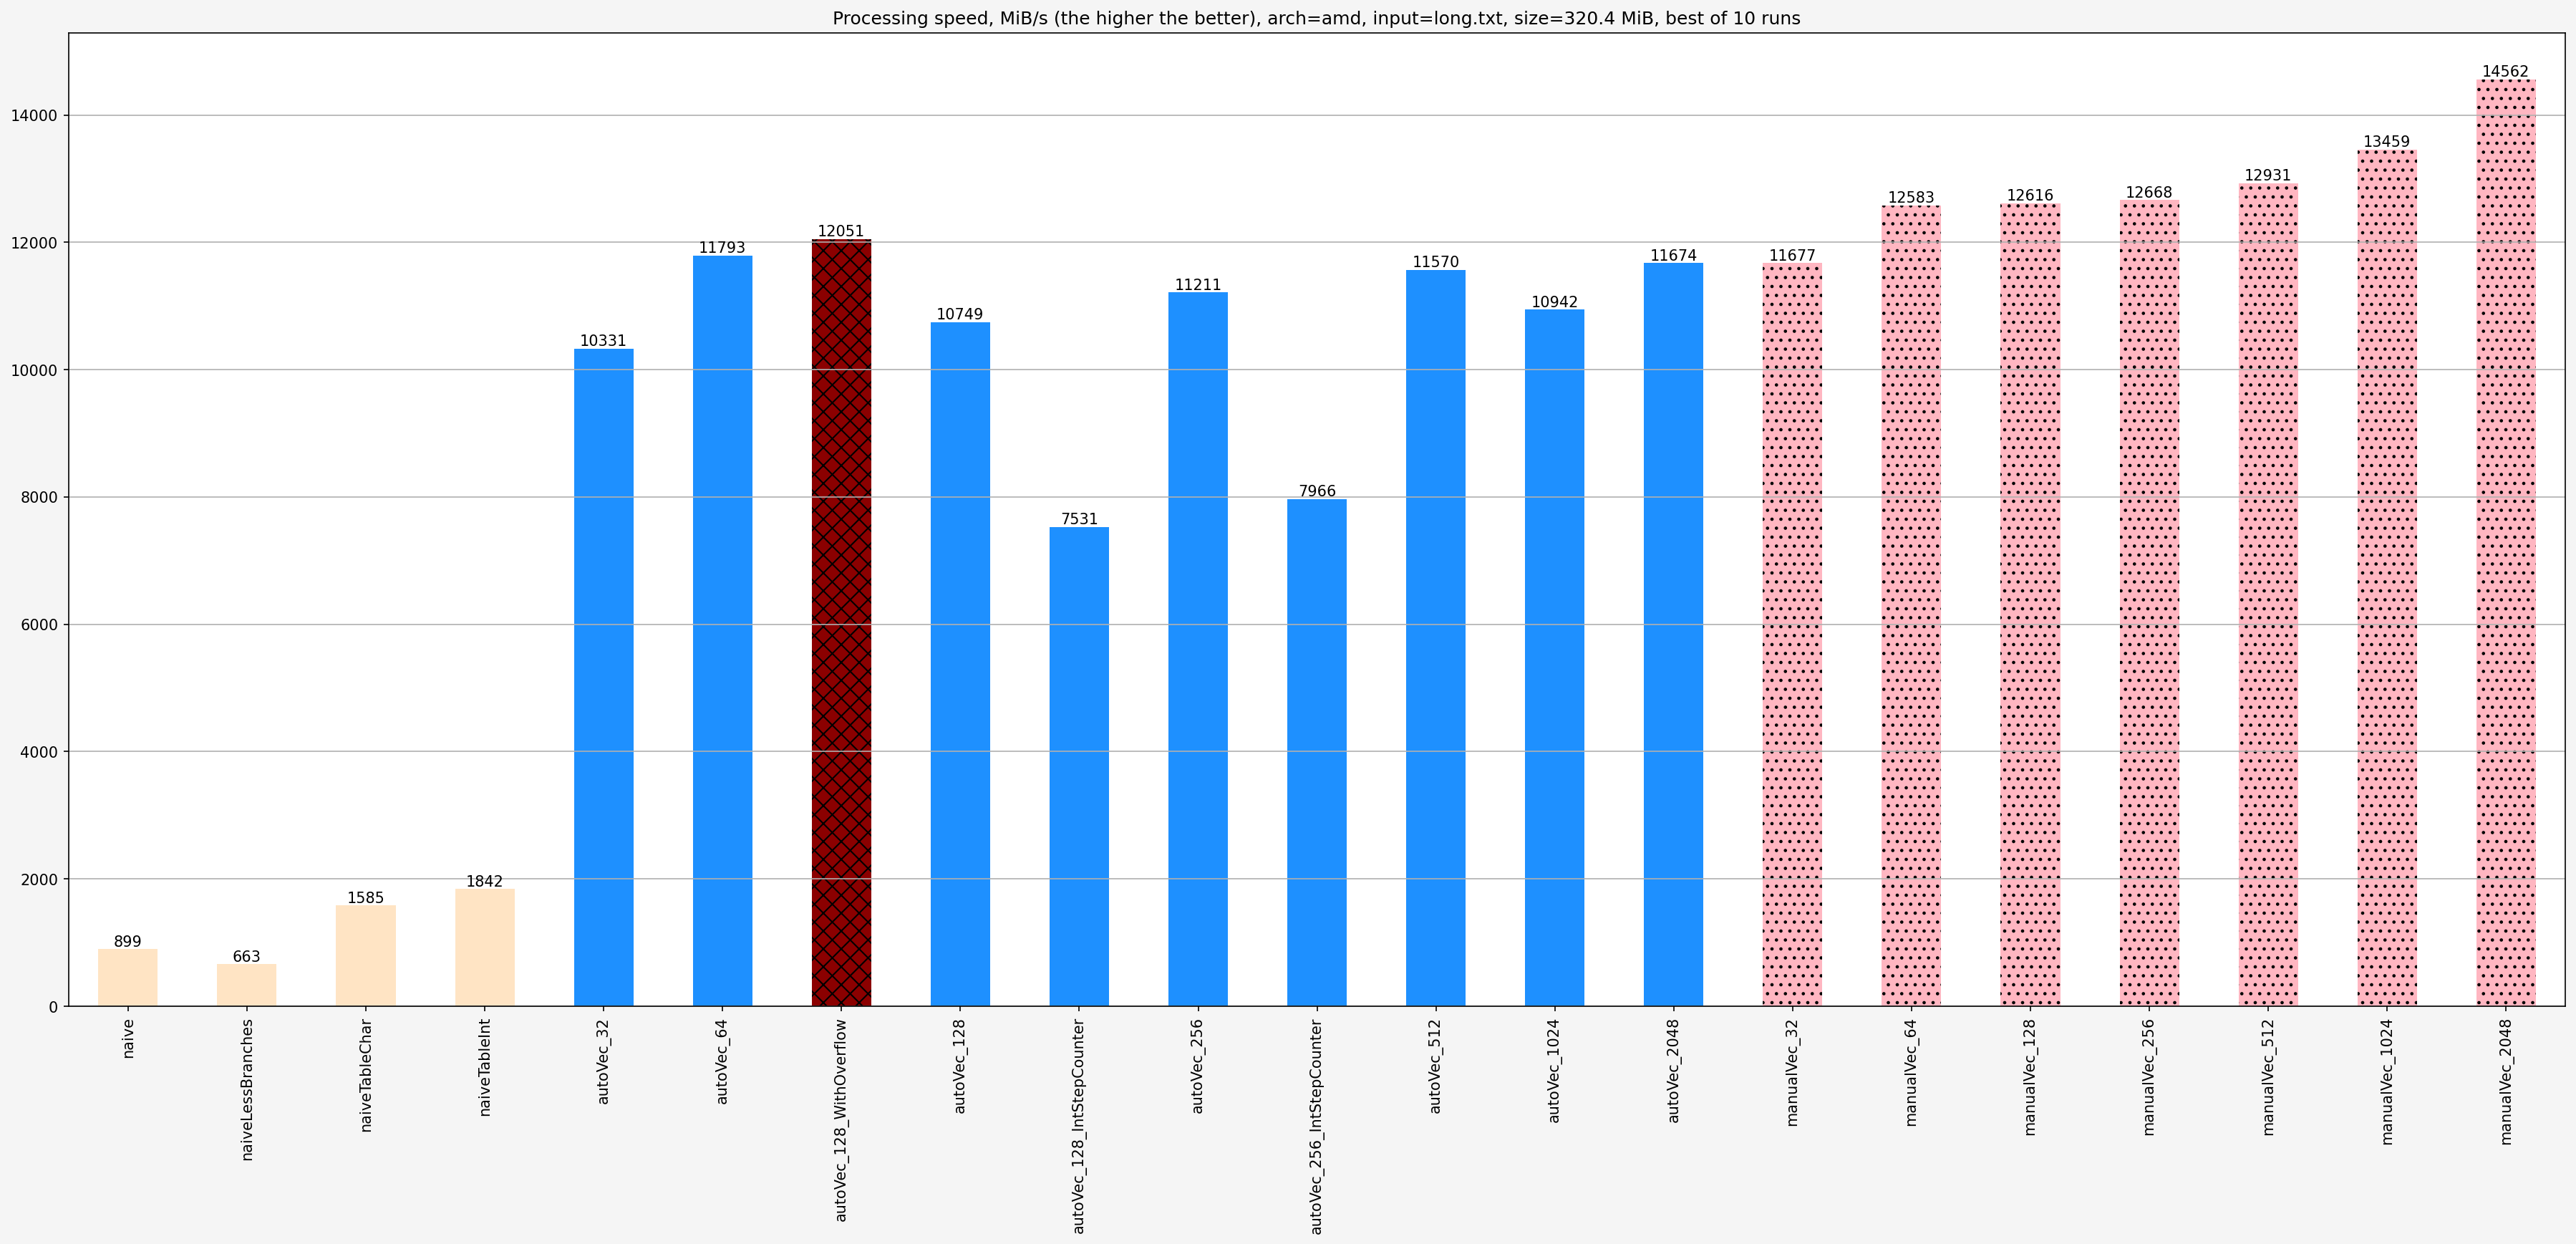

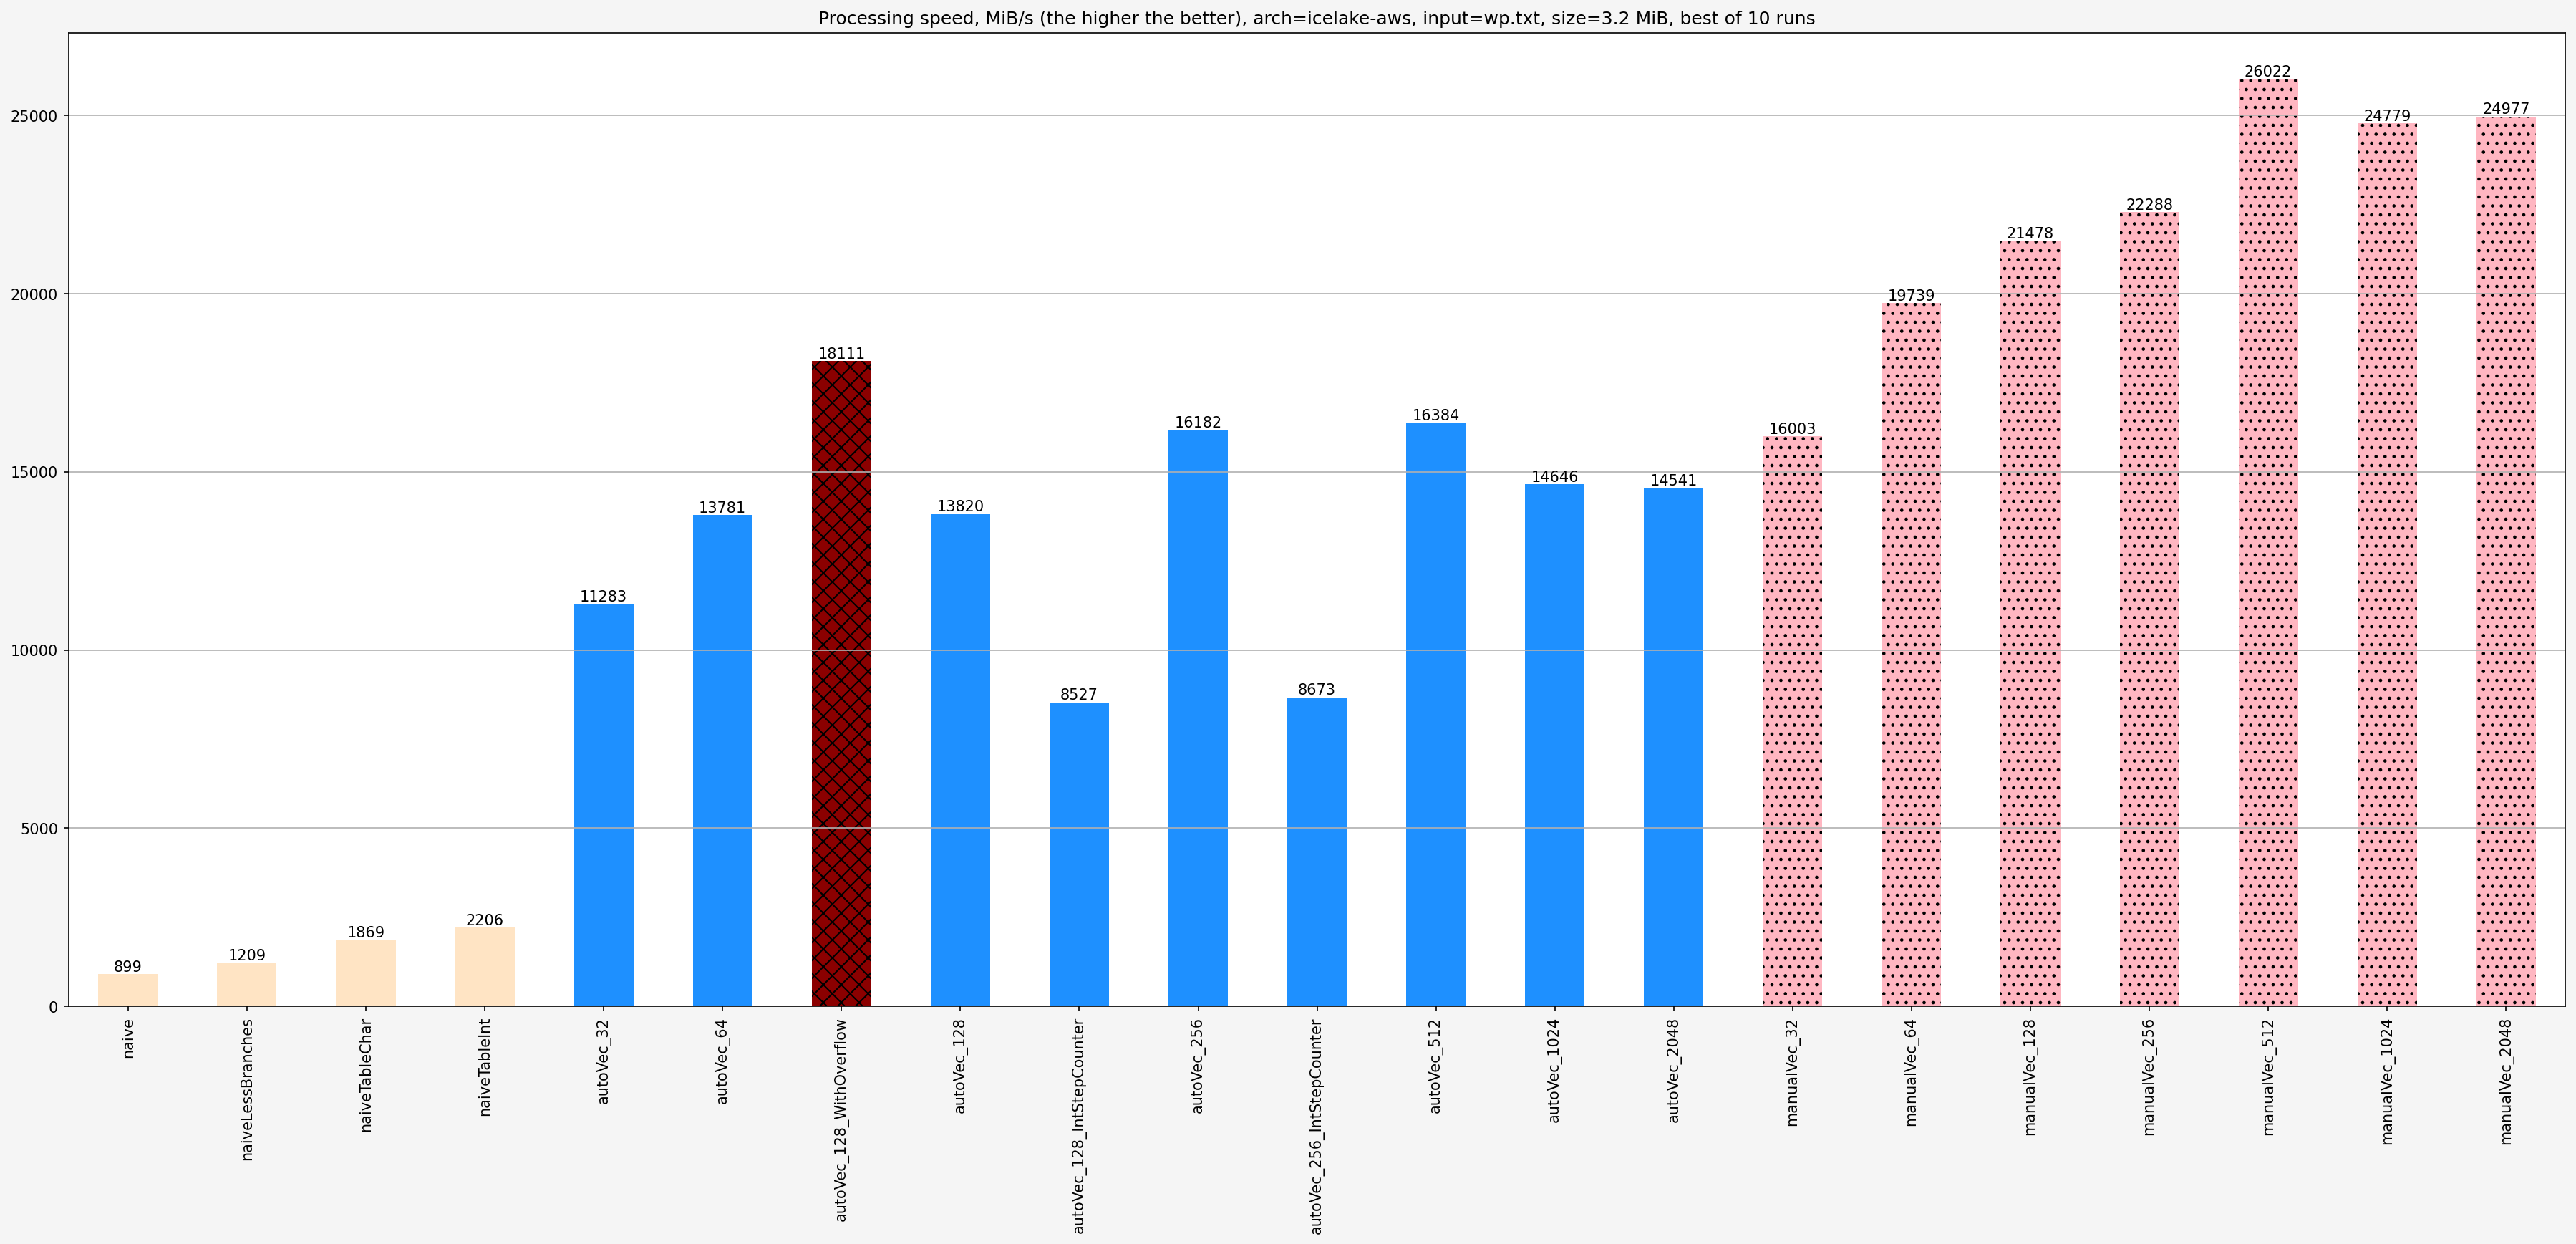

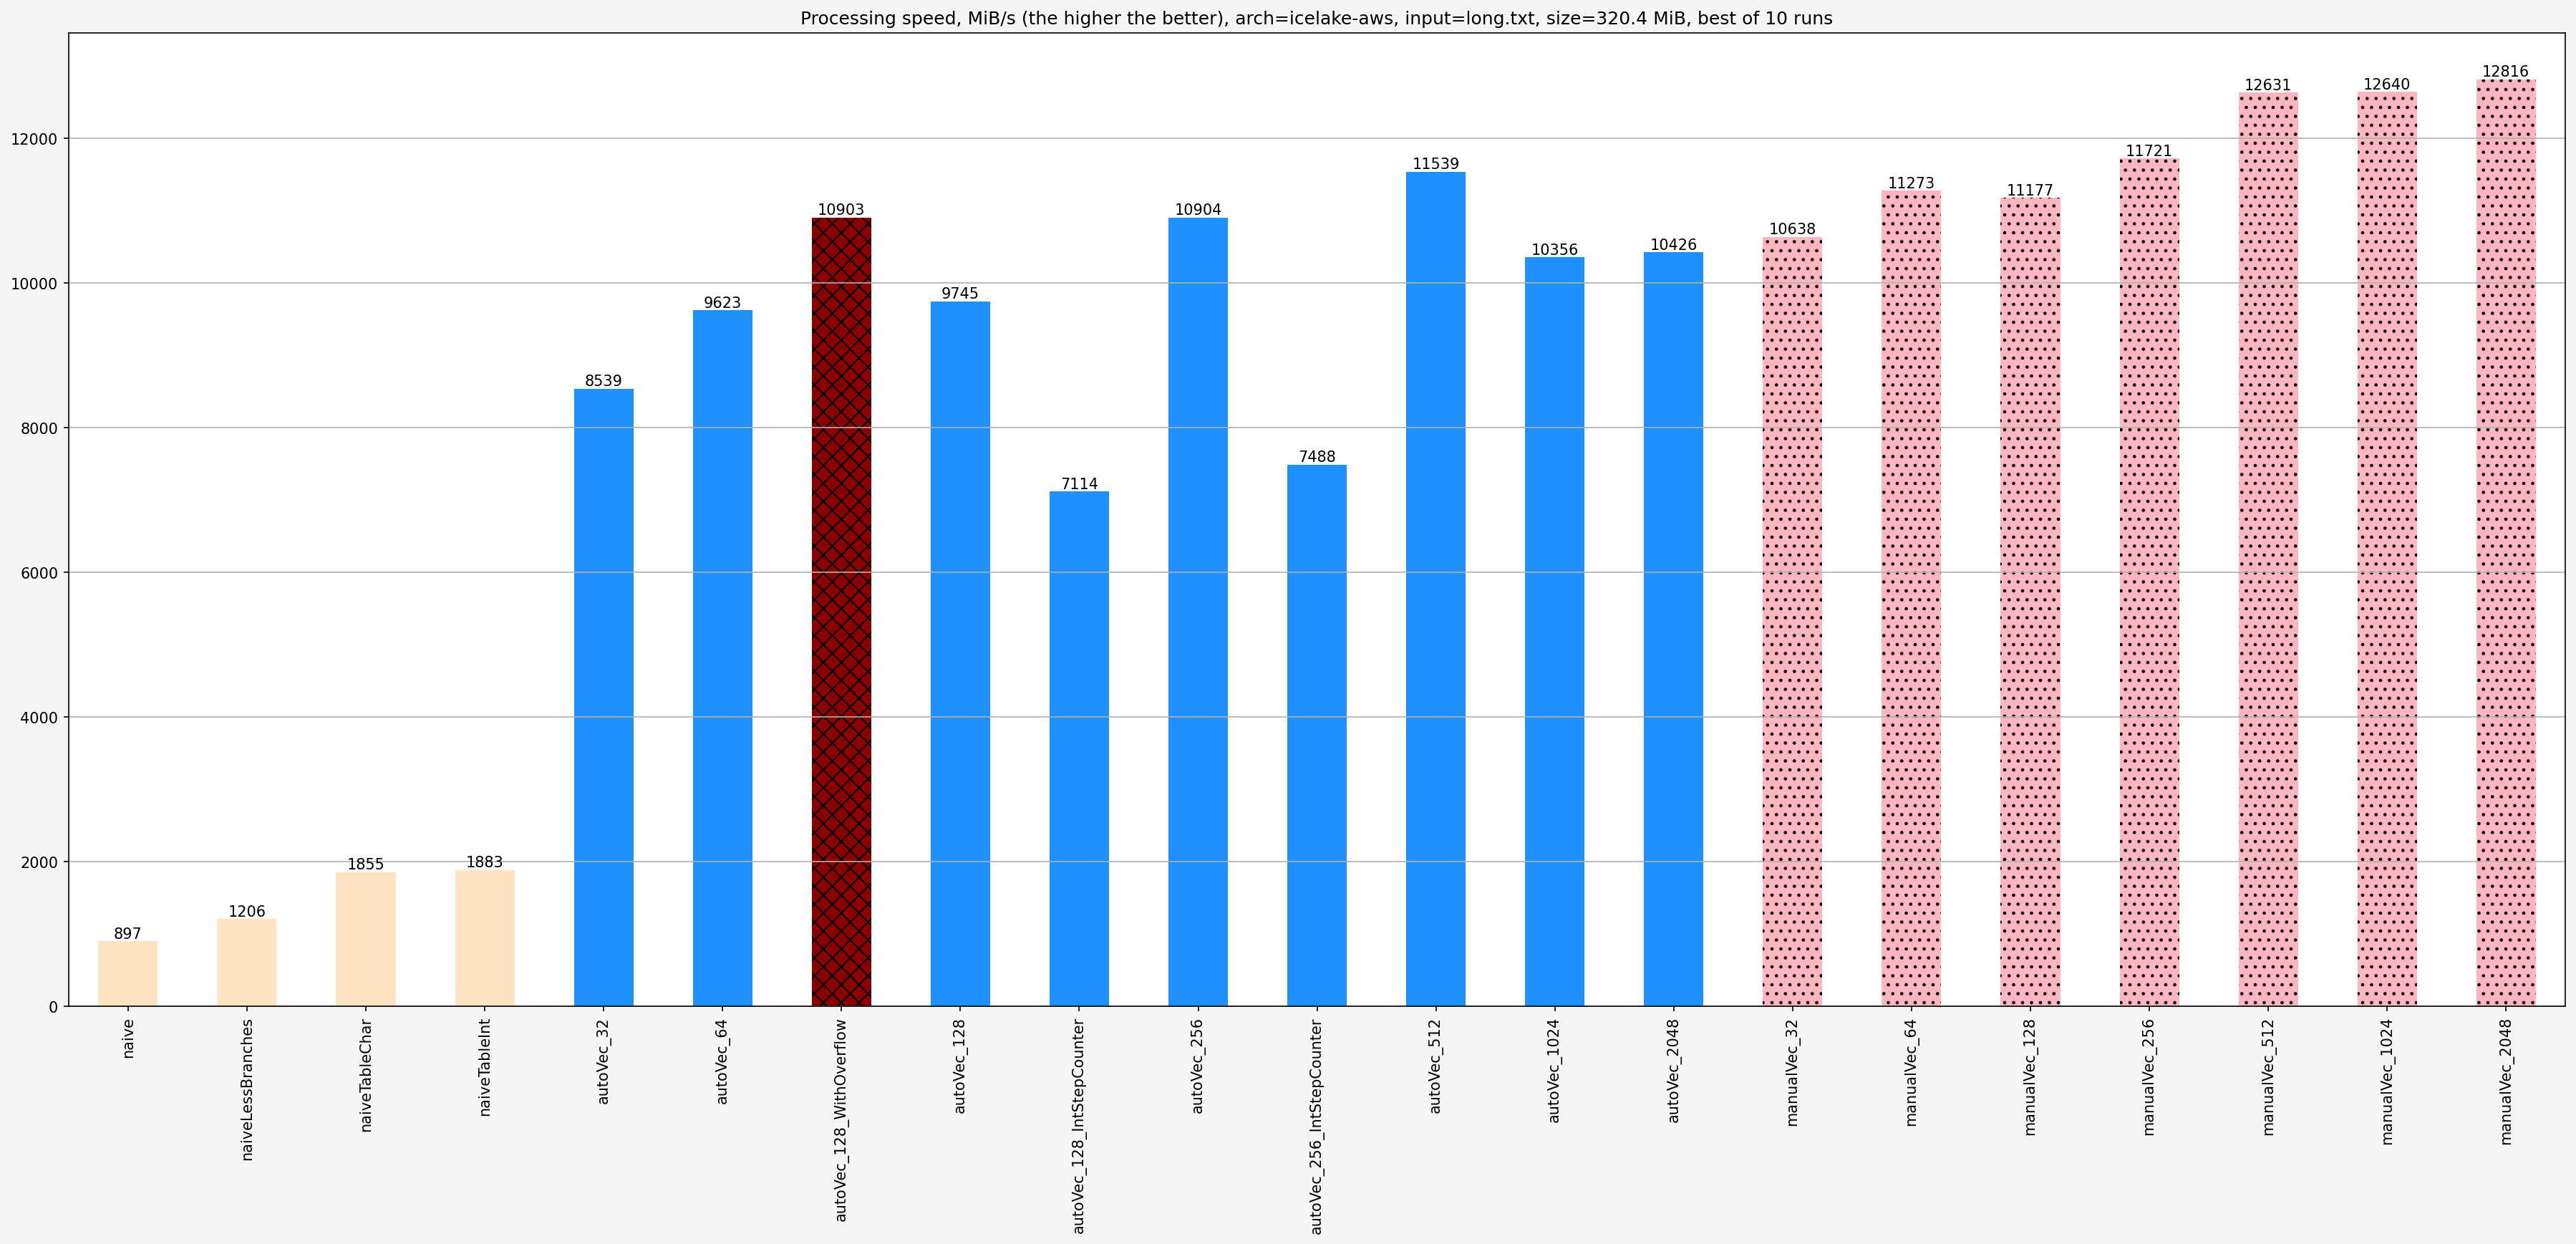

In [31]:
algos1 = [
    'naive',
    'naiveLessBranches',
    'naiveTableChar',
    'naiveTableInt',
    'autoVec_32',
    'autoVec_64',
    'autoVec_128_WithOverflow',
    'autoVec_128',
    'autoVec_128_IntStepCounter',
    'autoVec_256',
    'autoVec_256_IntStepCounter',
    'autoVec_512',
    'autoVec_1024',
    'autoVec_2048',
    'manualVec_32',
    'manualVec_64',
    'manualVec_128',
    'manualVec_256',
    'manualVec_512',
    'manualVec_1024',
    'manualVec_2048',
]

hatches = [HATCHES[all_algos[a]] for a in algos1]
colors = [COLORS[all_algos[a]] for a in algos1]

for arch, df in data.items():
    inputs = df['input'].unique()
    for i, inp in enumerate(inputs):
        df1 = df[df['algo'].isin(algos1) & (df['input'] == inp)]
        g = df1.groupby(['algo']).max('mib_per_s').reset_index().sort_values('algo', key=make_sorter(), ignore_index=True)
        plot, ax = plt.subplots(figsize=(30, 12), facecolor='whitesmoke')
        inp_size = g["input_size"][0] / 1024 / 1024
        fig = g.plot.bar(x='algo', y='mib_per_s', ax=ax, title=f'Processing speed, MiB/s (the higher the better), arch={arch}, input={inp}, size={inp_size:.1f} MiB, best of {NUM_RUNS} runs', legend=False, hatch=hatches, color=colors)
        ax.set(xlabel=None)
        ax.grid(which='both', axis='y')
        ax.bar_label(ax.containers[0])

# Comparison of processing speed between algorithms that take null-terminated and known size input

Variants:
- **autoVec** - takes null-terminated string as input
- **autoVecSize** - takes input buffer and size
- **autoVecSizeUnaligned** - same as **autoVecSize** but loading blocks with unaligned load
- **autoVecStrlen** - `strlen` + **autoVecSize**

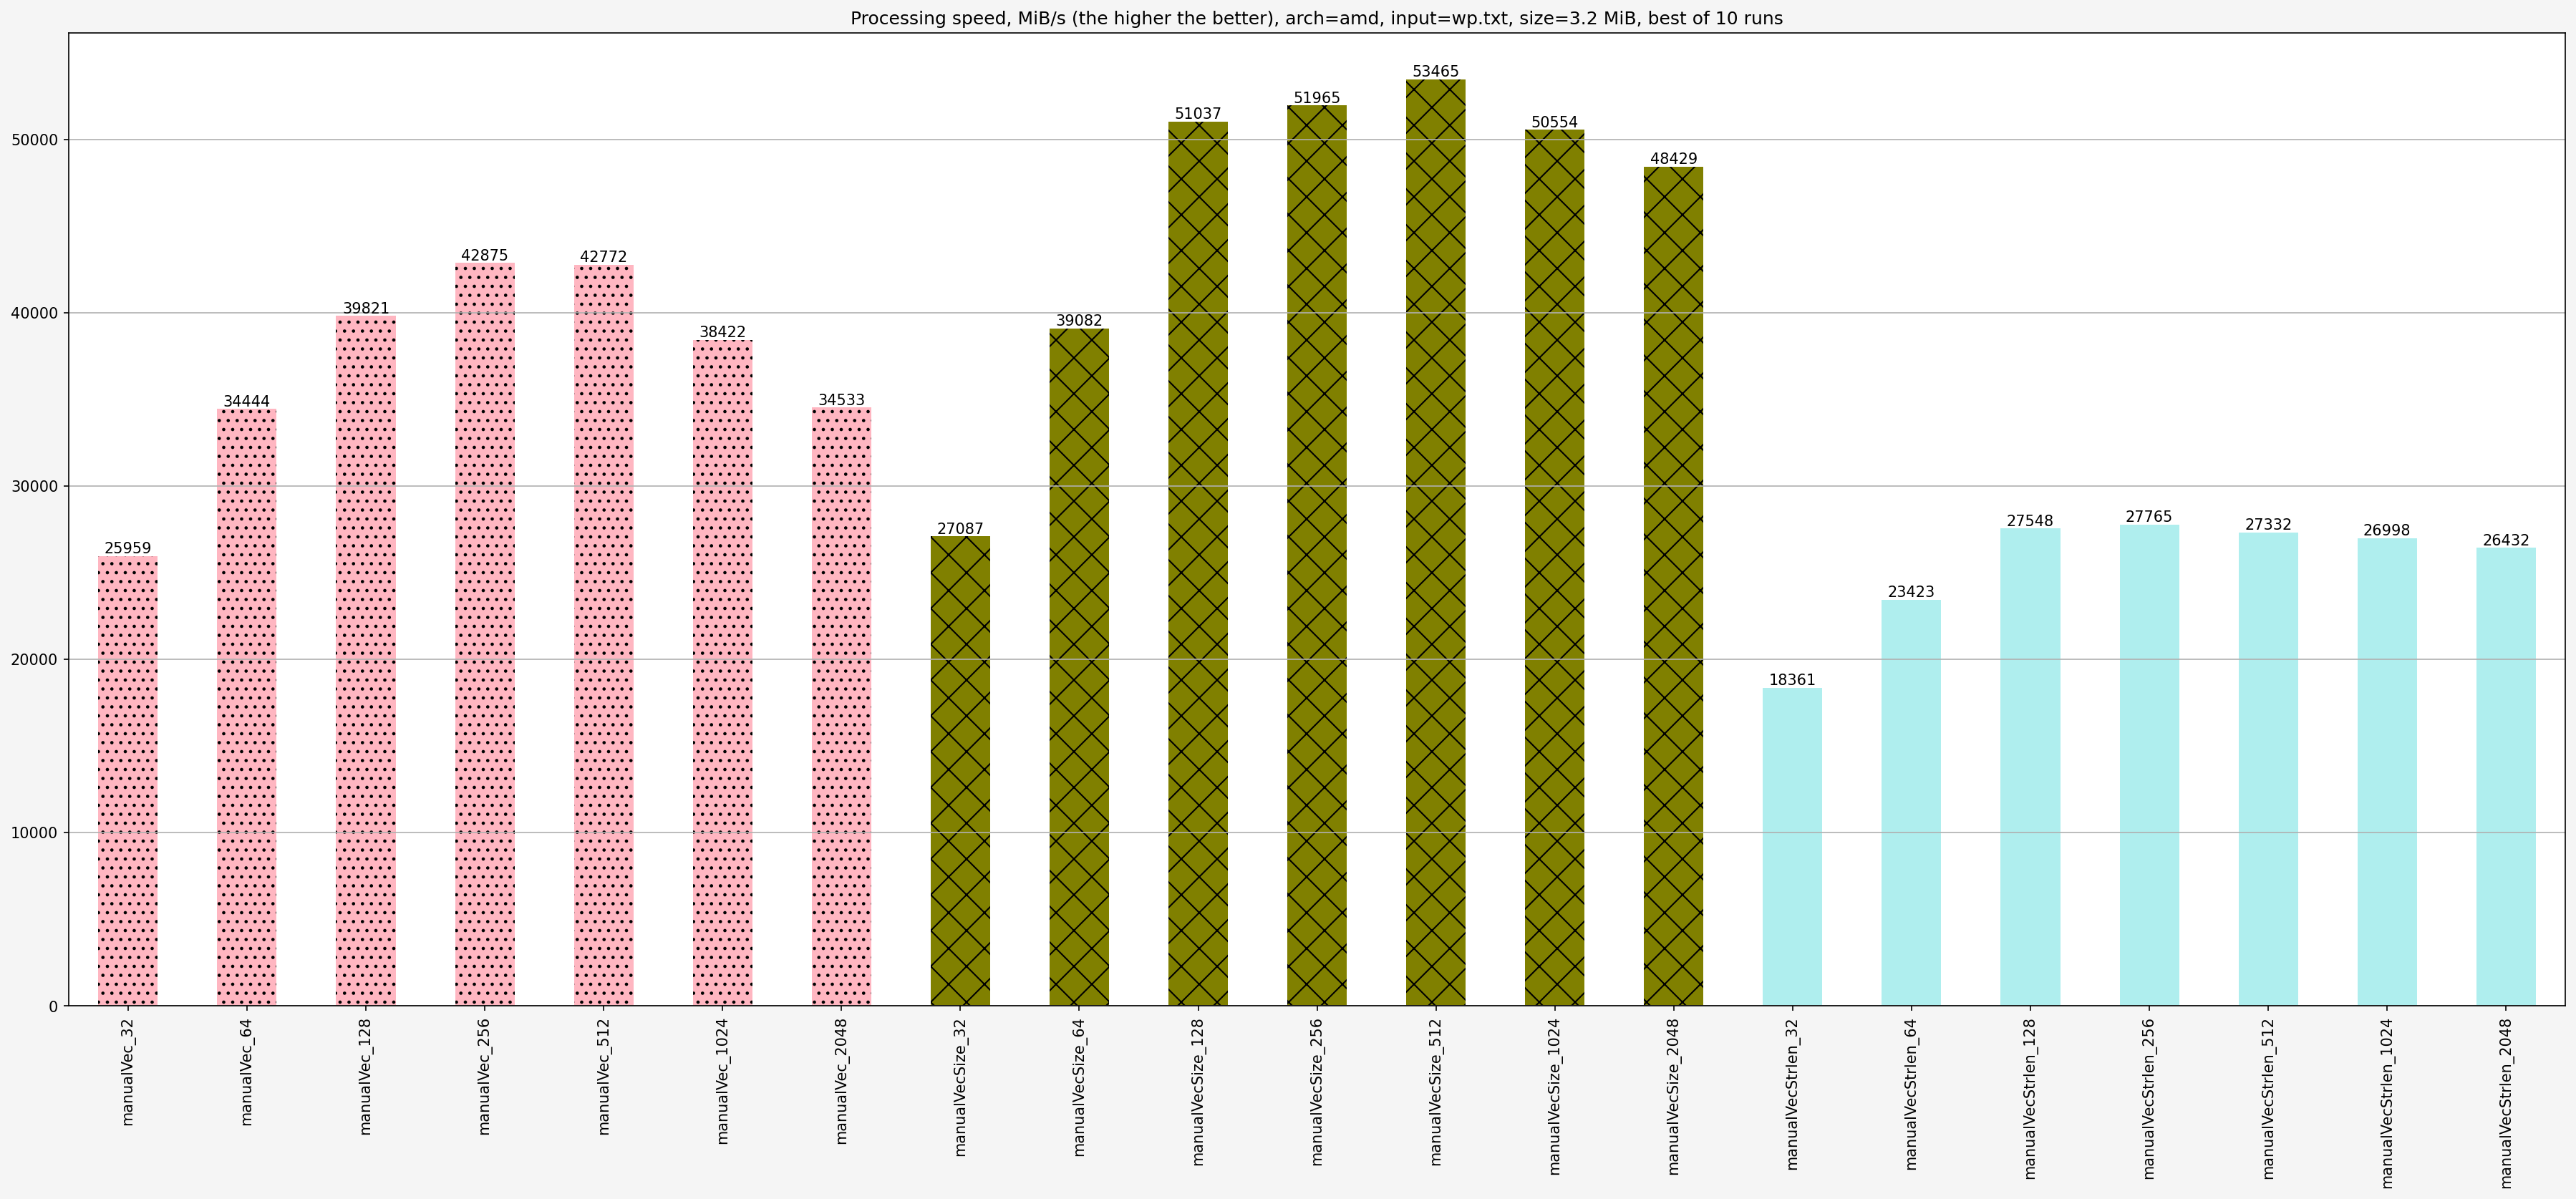

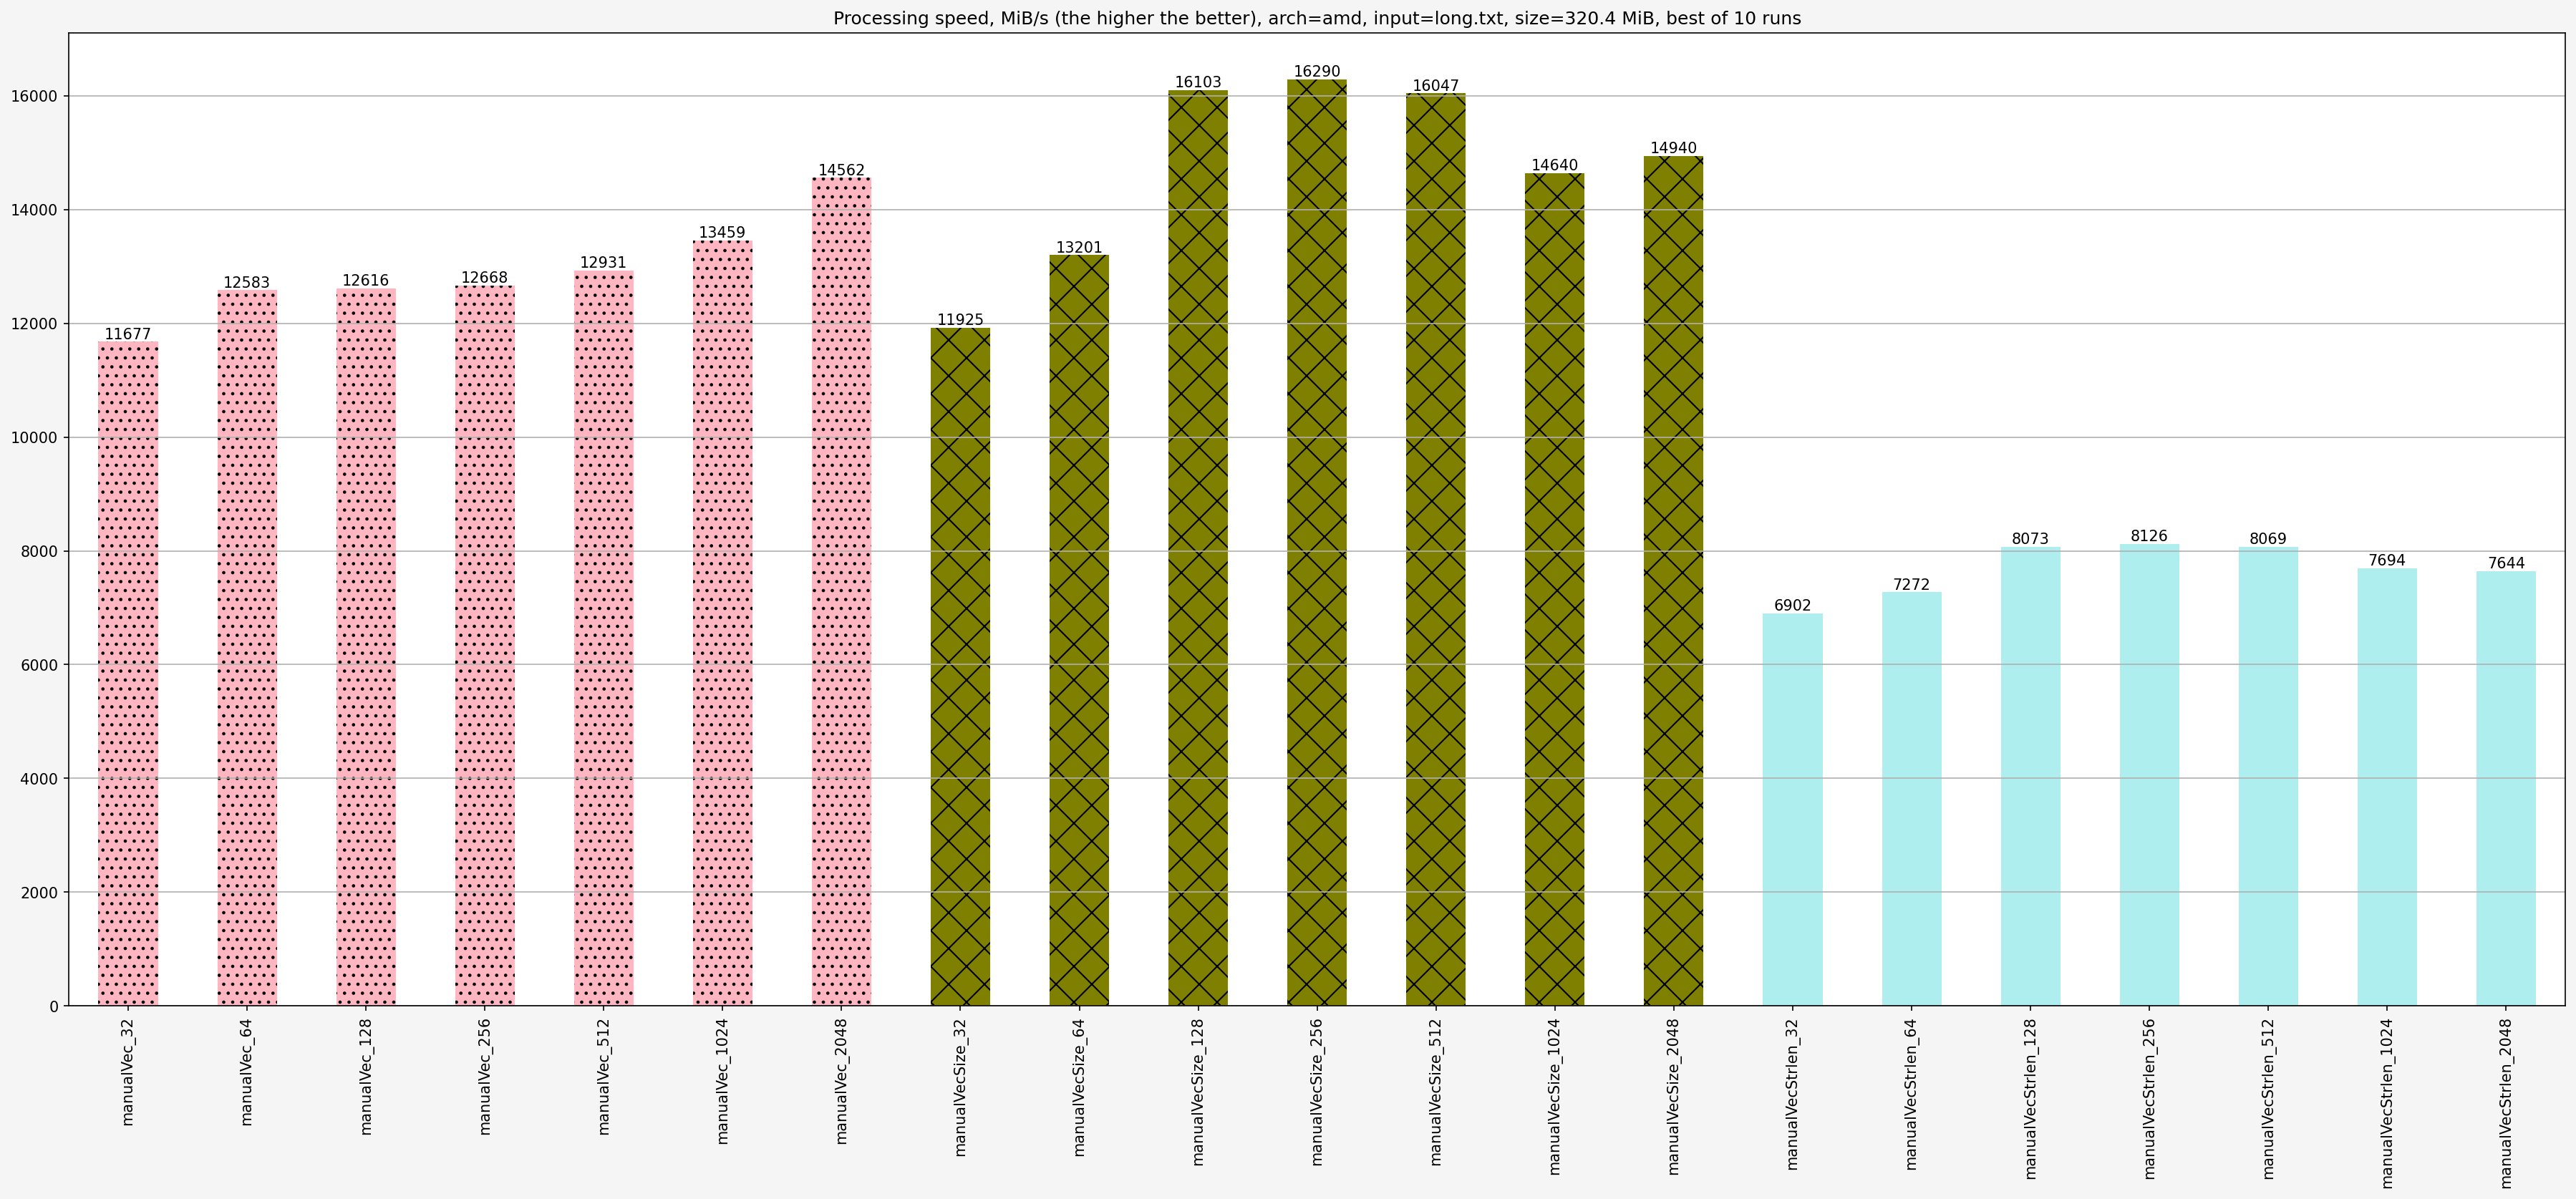

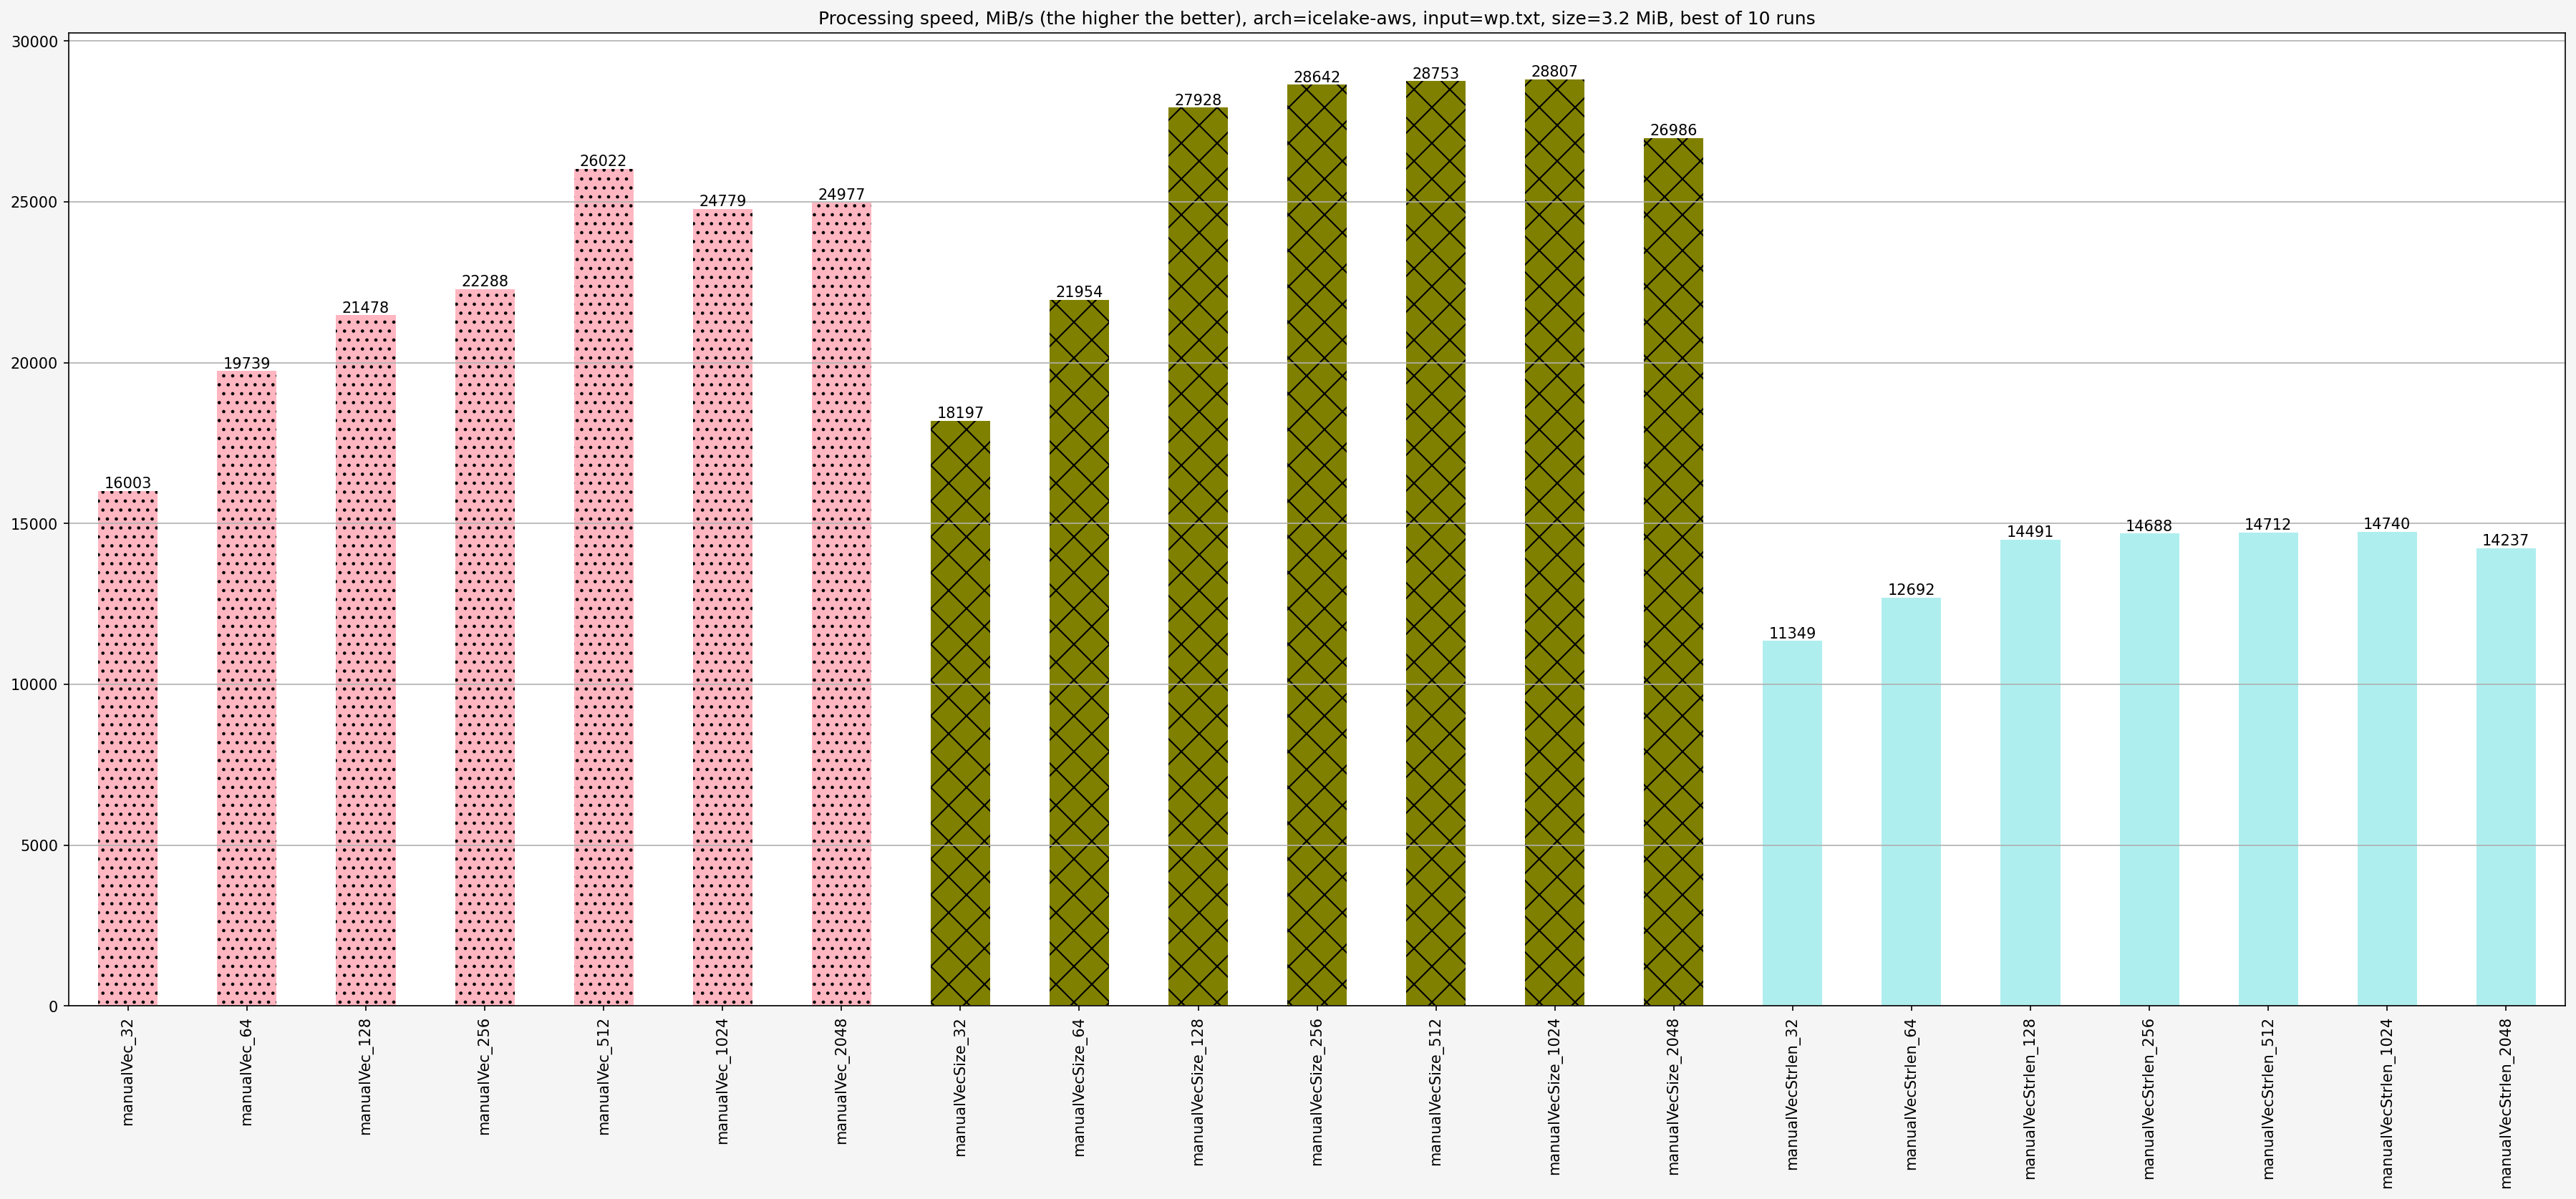

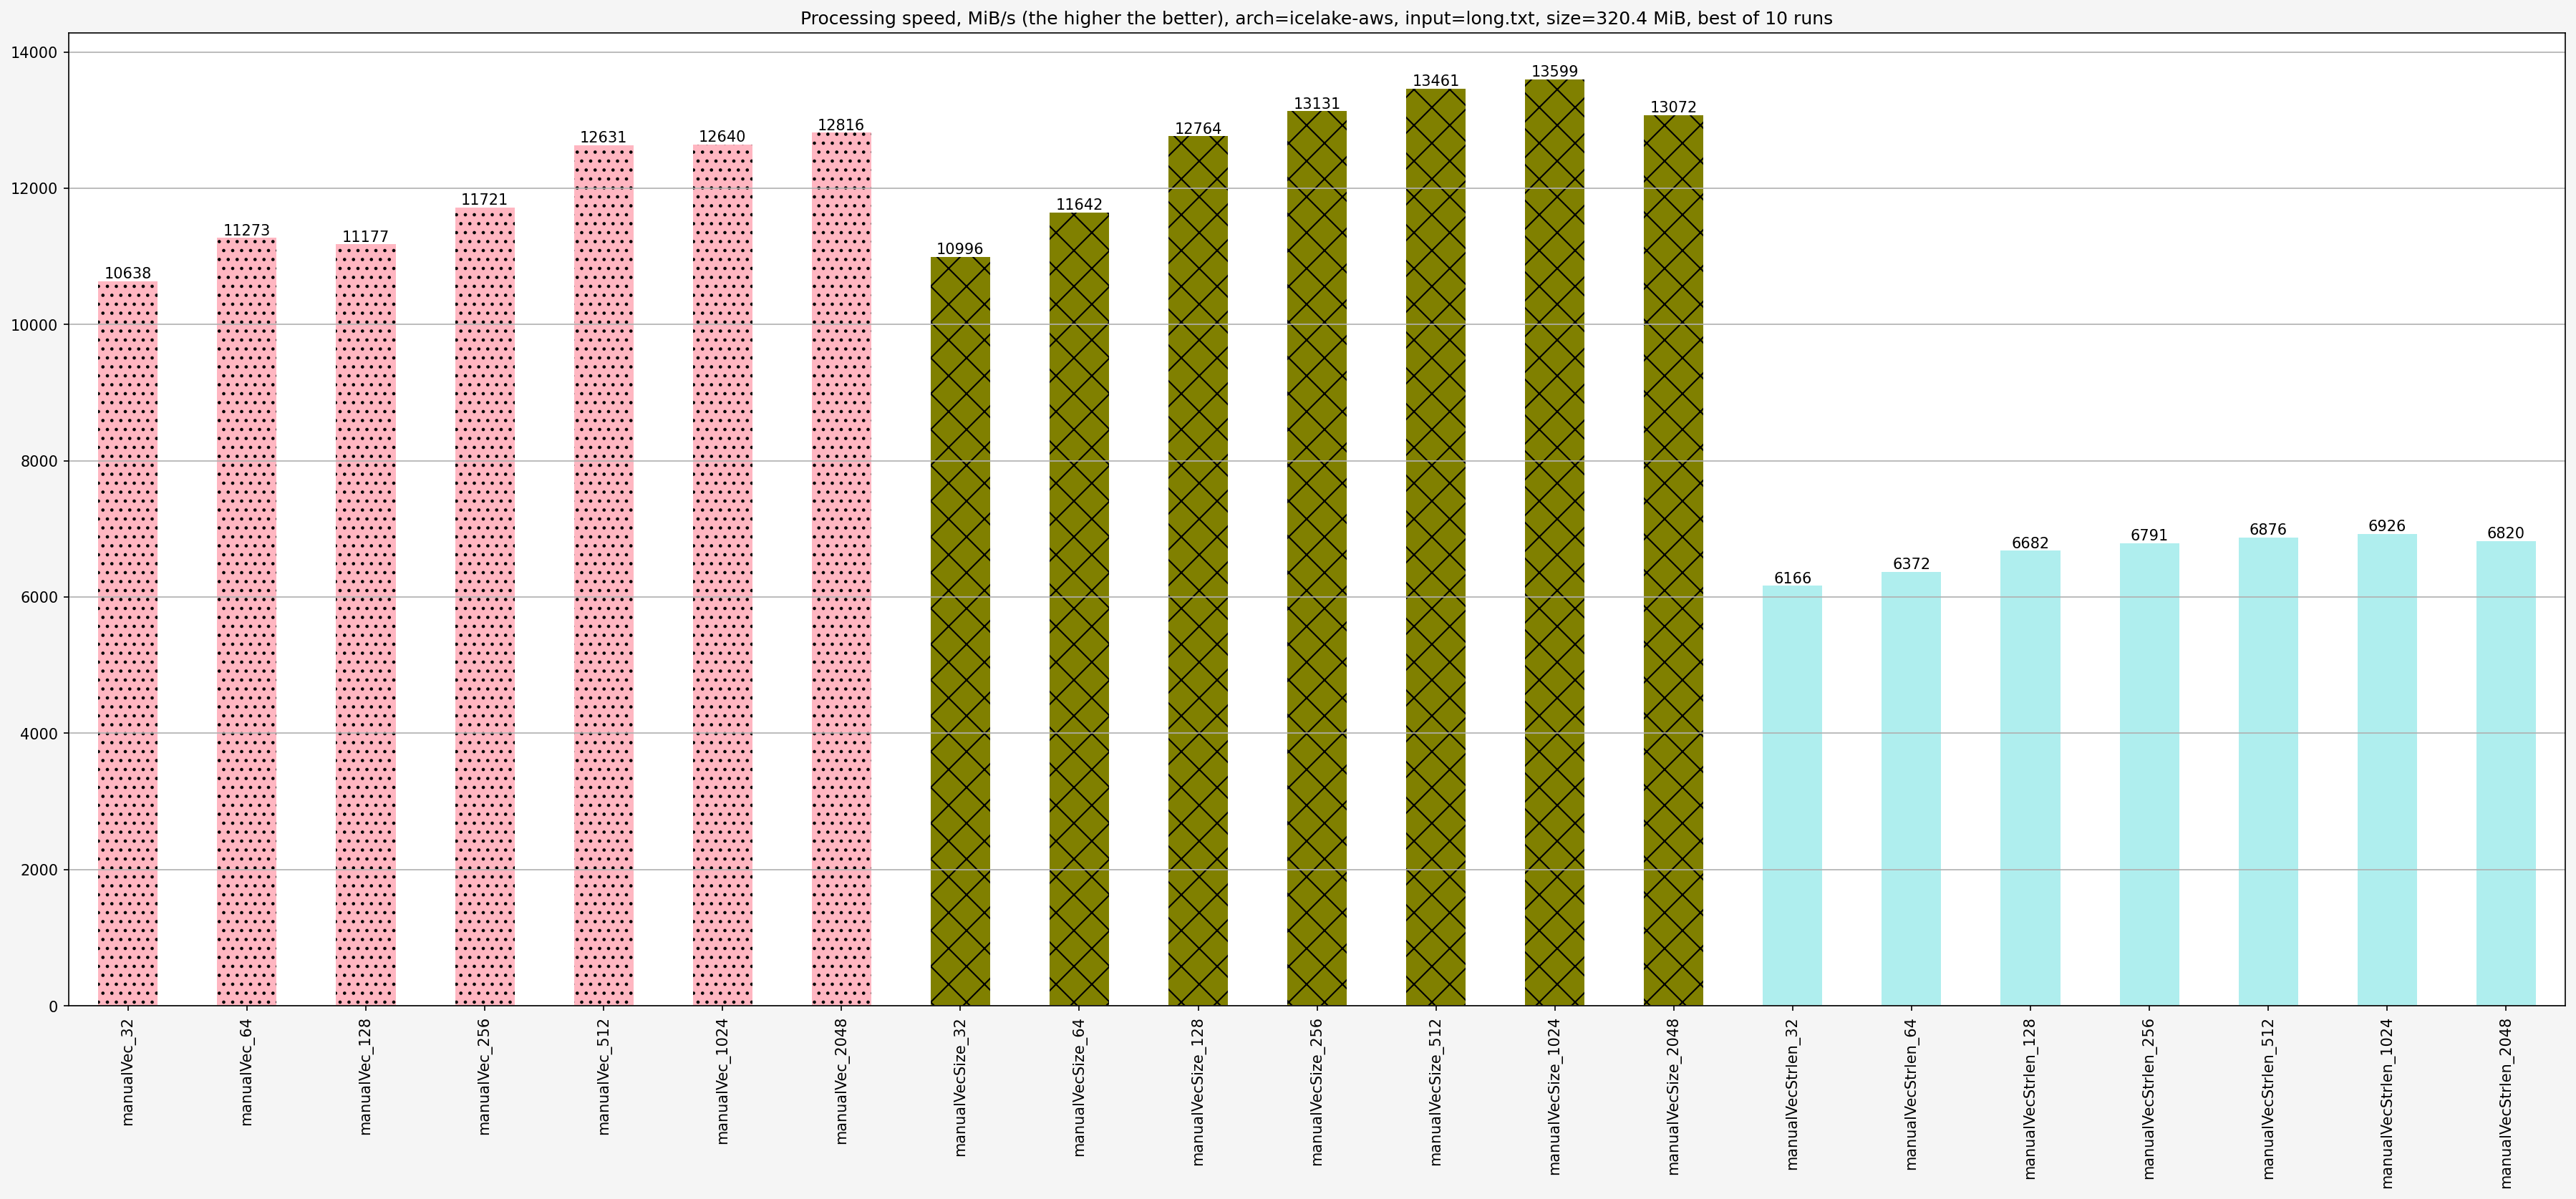

In [32]:
algos2 = [
    'manualVec_32',
    'manualVec_64',
    'manualVec_128',
    'manualVec_256',
    'manualVec_512',
    'manualVec_1024',
    'manualVec_2048',

    'manualVecSize_32',
    'manualVecSize_64',
    'manualVecSize_128',
    'manualVecSize_256',
    'manualVecSize_512',
    'manualVecSize_1024',
    'manualVecSize_2048',

    'manualVecStrlen_32',
    'manualVecStrlen_64',
    'manualVecStrlen_128',
    'manualVecStrlen_256',
    'manualVecStrlen_512',
    'manualVecStrlen_1024',
    'manualVecStrlen_2048',
]

hatches = [HATCHES[all_algos[a]] for a in algos2]
colors = [COLORS[all_algos[a]] for a in algos2]

for arch, df in data.items():
    for i, inp in enumerate(inputs):
        df1 = df[df['algo'].isin(algos2) & (df['input'] == inp)]
        g = df1.groupby(['algo']).max('mib_per_s').reset_index().sort_values('algo', key=make_sorter(), ignore_index=True)
        plot, ax = plt.subplots(figsize=(30, 12), facecolor='whitesmoke')
        inp_size = g["input_size"][0] / 1024 / 1024
        fig = g.plot.bar(x='algo', y='mib_per_s', ax=ax, title=f'Processing speed, MiB/s (the higher the better), arch={arch}, input={inp}, size={inp_size:.1f} MiB, best of {NUM_RUNS} runs', legend=False, hatch=hatches, color=colors)
        ax.set(xlabel=None)
        ax.grid(which='both', axis='y')
        ax.bar_label(ax.containers[0])